# Lake Baringo Animations


* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

## Description

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image

sys.path.append('../Scripts')
from deafrica_plotting import xr_animation, rgb, display_map
from deafrica_datahandling import load_ard
from deafrica_dask import create_local_dask_cluster
from deafrica_bandindices import calculate_indices
from deafrica_classificationtools import HiddenPrints

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43975 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Animated_timeseries')

## Load satellite data from datacube
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (i.e. Sentinel-2A and -2B), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels. 
This will allow us to create a visually appealing time series animation of observations that are not affected by cloud.

In the example below, we request that the function returns only observations which are 95% free of clouds and other poor quality pixels by specifyinge `min_gooddata=0.95`.

In [4]:
lat, lon = 0.6147, 36.0766  # Bui Reservoir inlet
buffer = 0.1
lat_buffer = 0.16
min_gooddata = 0.50

x = (lon - buffer, lon + buffer)
y =  (lat + lat_buffer, lat - lat_buffer)

# Create a reusable query
query = {'x': x,
        'y': y,
        'time': ('2013', '2021'),
        'resolution': (-30, 30),
         'group_by':'solar_day',
         'output_crs':'epsg:6933',
         'dask_chunks':{'x':500, 'y':500},
}

In [5]:
# display_map(x, y)

In [6]:
# Load available data
with HiddenPrints():
    ds_s2 = load_ard(dc=dc, 
                  products=['s2_l2a'],
                  measurements=['red', 'green', 'blue', 'nir_1', 'swir_1'],
                  min_gooddata=min_gooddata,
                  mask_pixel_quality=True,
                  **query)

# Print output data
print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 215, x: 644, y: 1362)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T08:07:11 ... 2021-03-12T08:...
  * y            (y) float64 9.884e+04 9.880e+04 ... 5.804e+04 5.800e+04
  * x            (x) float64 3.471e+06 3.471e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir_1        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [7]:
with HiddenPrints():
    ds_ls = load_ard(dc=dc, 
                  products=['ls8_usgs_sr_scene'],
                  measurements=['red', 'green', 'blue', 'nir', 'swir1'],
                  min_gooddata=min_gooddata,
                  mask_pixel_quality=True,
                  **query)
print(ds_ls)

<xarray.Dataset>
Dimensions:      (time: 127, x: 644, y: 1362)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-28T07:50:19.704022 ... 2020-01...
  * y            (y) float64 9.884e+04 9.880e+04 ... 5.804e+04 5.800e+04
  * x            (x) float64 3.471e+06 3.471e+06 ... 3.491e+06 3.491e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [8]:
ds_ls = calculate_indices(ds_ls, index=['MNDWI', 'EVI'], collection='c1')
ds_s2 = calculate_indices(ds_s2, index=['MNDWI', 'EVI'], collection='s2')

In [9]:
ds_s2 = ds_s2.drop(['nir_1', 'swir_1'])
ds_ls = ds_ls.drop(['nir', 'swir1'])

In [10]:
ds = xr.concat([ds_ls,ds_s2], dim='time').sortby('time').compute()

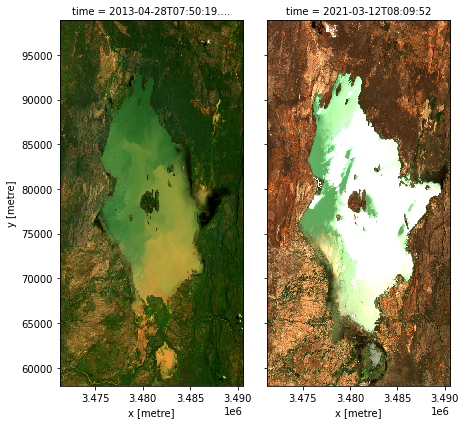

In [11]:
# Plot first and last images from the dataset
rgb(ds, index=[0,-1])

## interpolate/smooth

In [12]:
ds = ds.resample(time='1M', label='left', loffset='2W').median('time')

In [13]:
ds = ds.rolling(time=3, min_periods=1).median()

## Plot time series as a RGB/three band animated GIF


In [14]:
interval=200
width_pixels=300

In [ ]:
# Produce time series animation of red, green and blue bands
name='rgb_lake_baringo_2013_2021.gif'

xr_animation(ds=ds, 
             bands=['red', 'green', 'blue'],
             output_path=name,                                
             interval=interval, 
             width_pixels=width_pixels) 

# Plot animated gif
plt.close()
Image(filename=name)

Exporting animation to rgb_lake_baringo_2013_2021.gif


  0%|          | 0/96 (0.0 seconds remaining at ? frames/s)

### MNDWI
It is also possible to plot a single band image instead of a three band image. 
For example, we could plot an index like the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0). 


In [ ]:
# Produce time series animation of NDWI:
name='MNDWI_lake_baringo_2013_2021.gif'

xr_animation(ds=ds, 
             output_path=name,
             bands=['MNDWI'], 
             show_text='MNDWI', 
             width_pixels=width_pixels,
             interval=interval,
             imshow_kwargs={'cmap': 'Blues', 'vmin': 0.0, 'vmax': 0.5},
             colorbar_kwargs={'colors': 'black'}
            ) 

# Plot animated gif
plt.close()
Image(filename=name)

### EVI
It is also possible to plot a single band image instead of a three band image. 
For example, we could plot an index like the Normalized Difference Water Index (NDWI), which has high values where a pixel is likely to be open water (e.g. NDWI > 0). 


In [ ]:
# Produce time series animation of NDWI:
name='EVI_lake_baringo_2013_2021.gif'

xr_animation(ds=ds, 
             output_path=name,
             bands=['EVI'], 
             show_text='EVI', 
             width_pixels=width_pixels,
             interval=interval,
             imshow_kwargs={'cmap': 'Greens', 'vmin': 0., 'vmax': 0.7},
             colorbar_kwargs={'colors': 'black'}
            ) 

# Plot animated gif
plt.close()
Image(filename=name)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)